In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

# from sklearn.svm import SVC
# from xgboost import XGBClassifier
# from sklearn.linear_model import LogisticRegression
# from imblearn.over_sampling import RandomOverSampler

import os

import warnings 
warnings.filterwarnings('ignore')

dirname ='/kaggle/input/diabetes-health-indicators-dataset'
filename= 'diabetes_012_health_indicators_BRFSS2015.csv'
file = os.path.join(dirname, filename)

In [56]:
df = pd.read_csv(file)
print(df.head())
print(df.shape)
print(df.info())
print(df.describe().T)
print(df.isnull().sum())
print(df.columns)

   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0        4.0   
1     

In [57]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Check if any infinite values remain
print(np.isinf(df).sum())

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


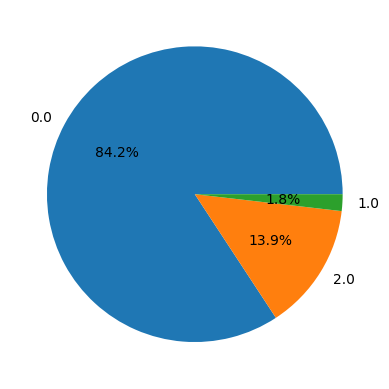

In [58]:
plt.pie(df['Diabetes_012'].value_counts().values,
        labels = df['Diabetes_012'].value_counts().index,
        autopct='%1.1f%%')

plt.show()

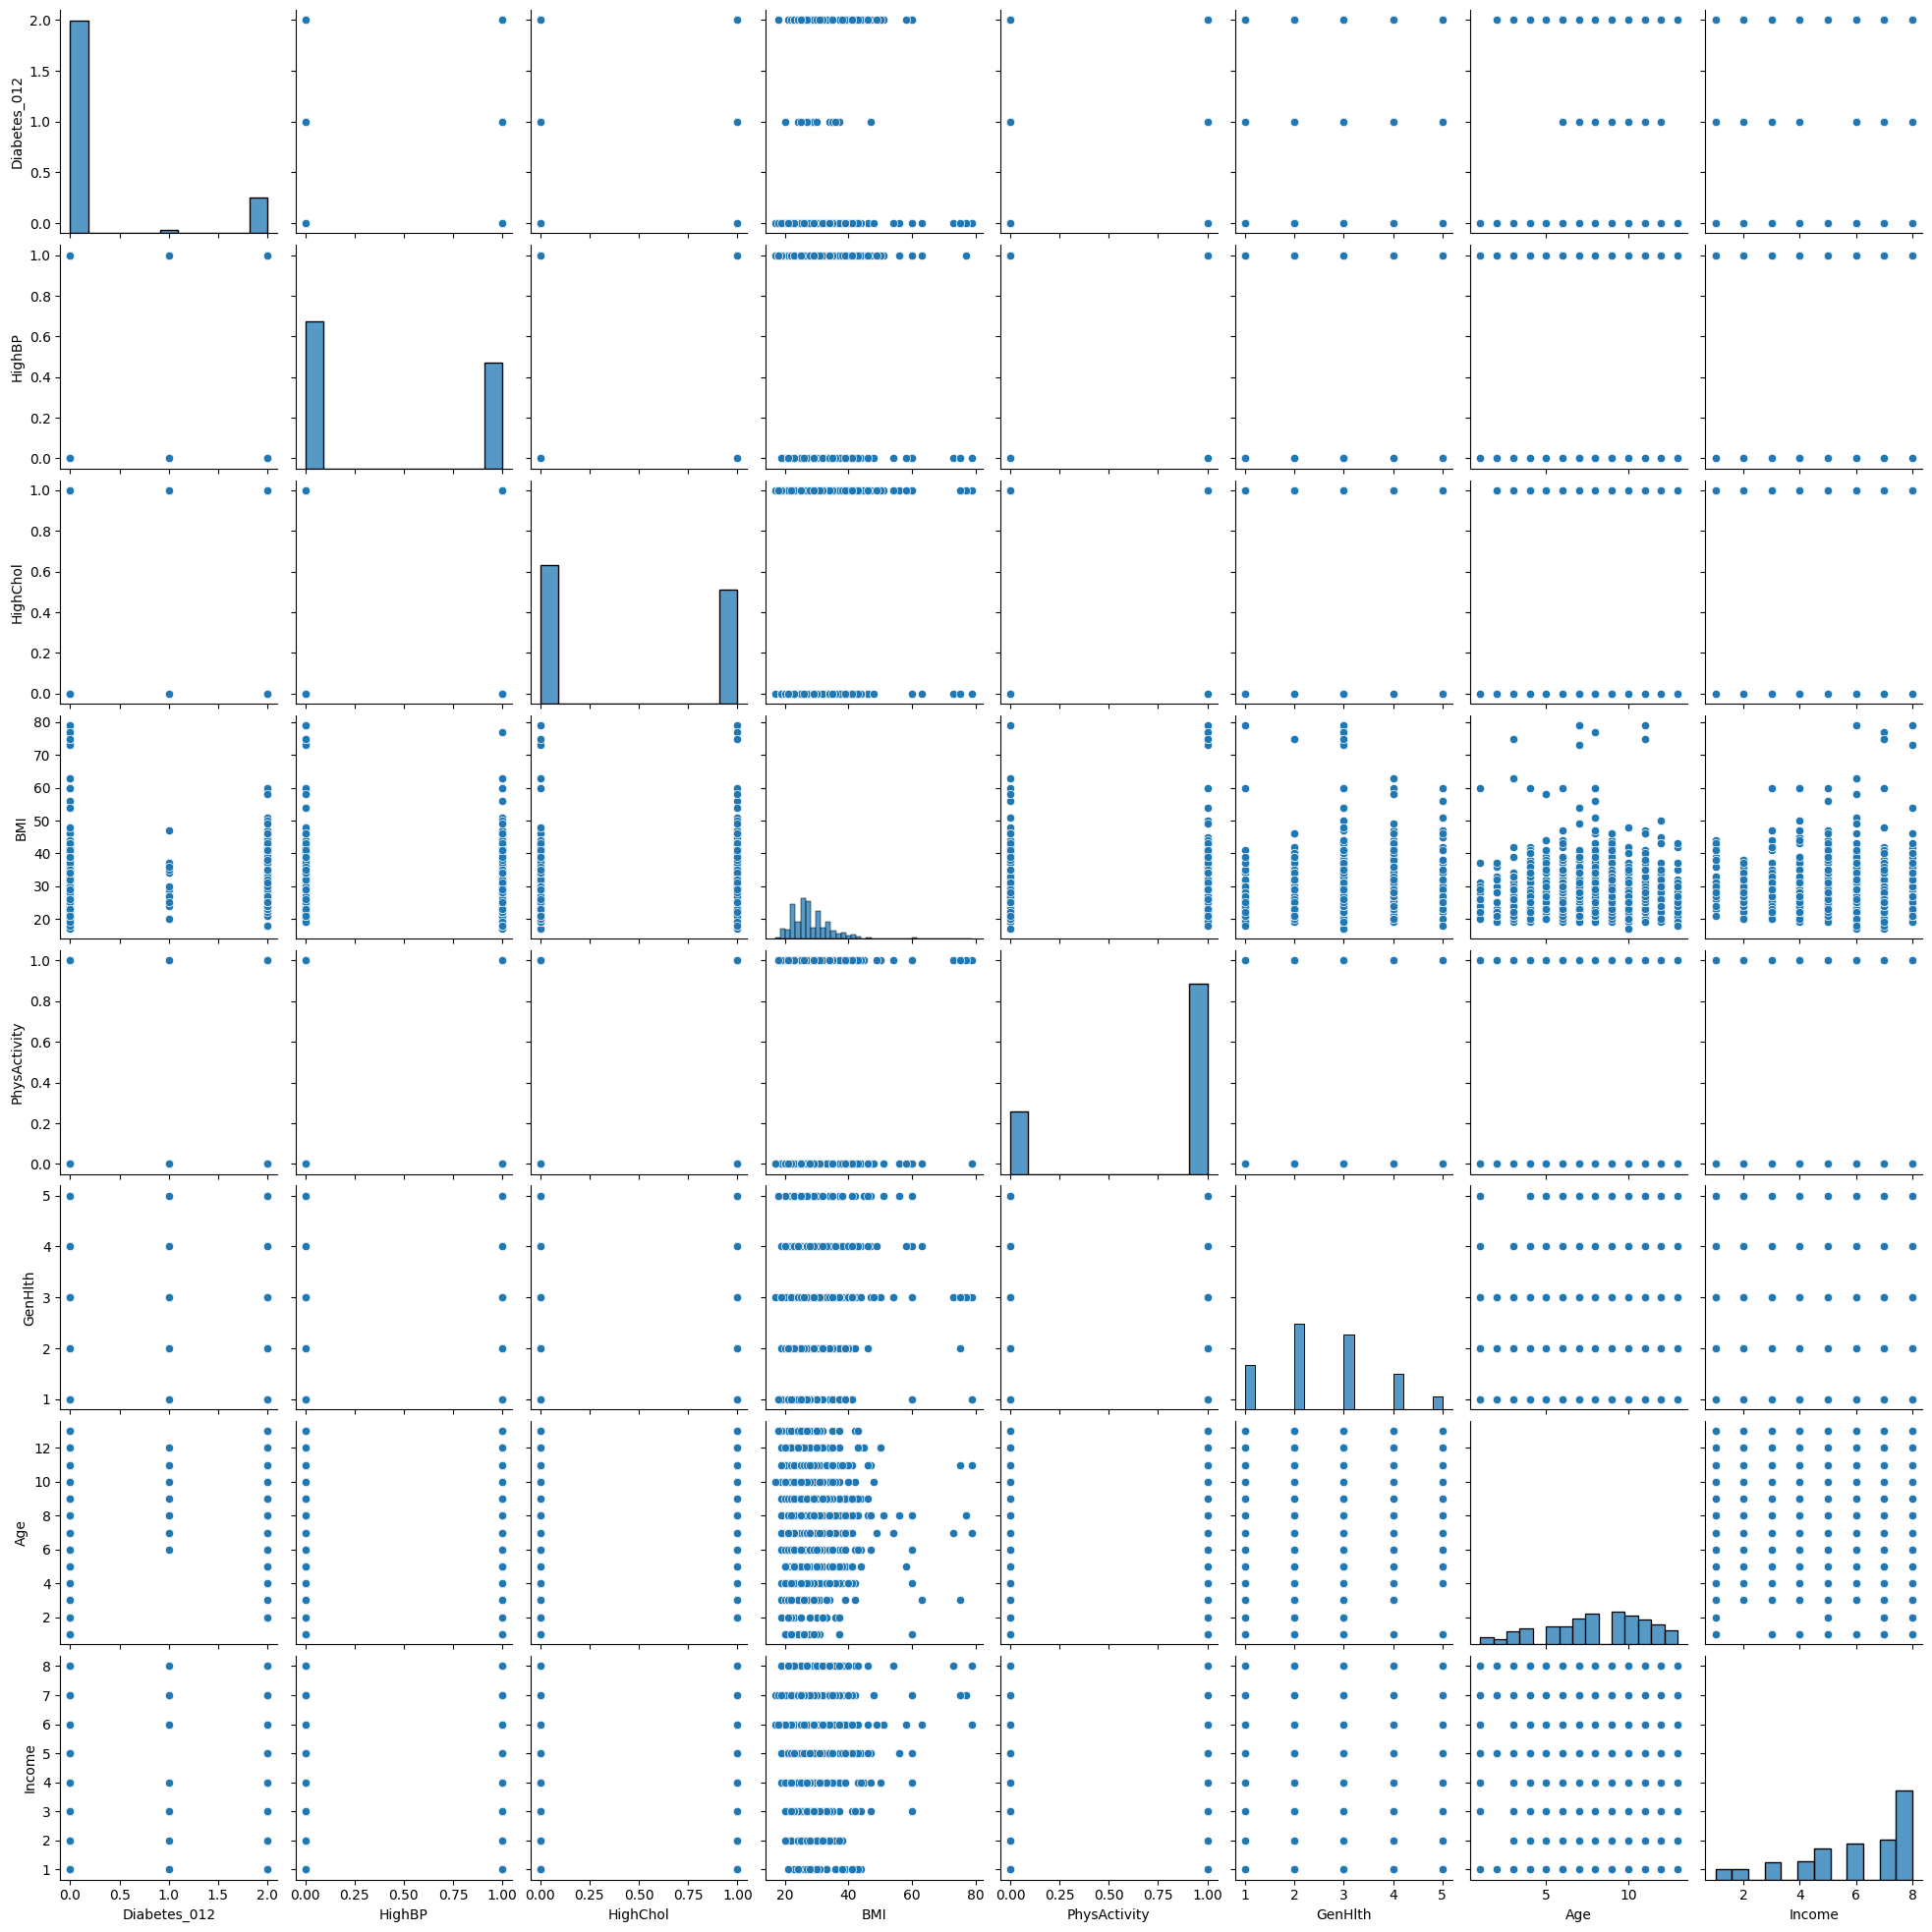

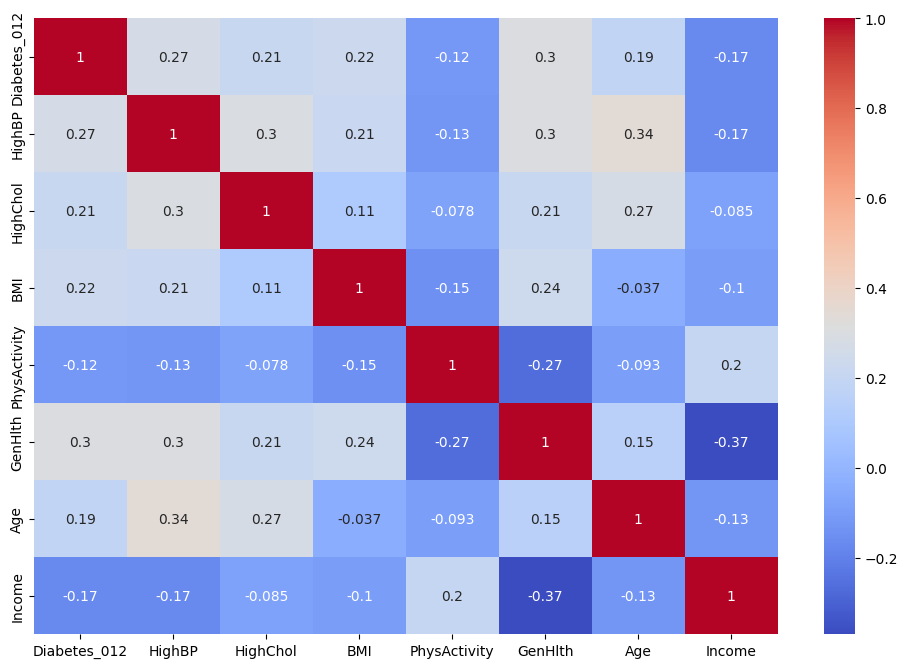

In [59]:
sampled_df = df.sample(n=1000, random_state=1)  # Adjust the number of samples as needed

# Selecting a subset of columns for pairplot
subset_columns = ['Diabetes_012', 'HighBP', 'HighChol', 'BMI', 'PhysActivity', 'GenHlth', 'Age', 'Income']
sb.pairplot(sampled_df[subset_columns])
plt.show()

# Correlation matrix with a subset of columns
corr_matrix = df[subset_columns].corr()
plt.figure(figsize=(12, 8))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [60]:
# features = df.drop(columns=['Diabetes_012'])  # Exclude the target column if necessary

# # Elbow Method
# wcss = []
# range_n_clusters = list(range(1, 11))

# for n_clusters in range_n_clusters:
#     kmeans = KMeans(n_clusters=n_clusters, random_state=0)
#     kmeans.fit(features)
#     wcss.append(kmeans.inertia_)

# # Plotting the Elbow Method results
# plt.figure(figsize=(8, 4))
# plt.plot(range_n_clusters, wcss, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Within-cluster Sum of Squares (WCSS)')
# plt.title('Elbow Method For Optimal Number of Clusters')
# plt.show()


   Diabetes_012    HighBP  HighChol  CholCheck        BMI    Smoker    Stroke  \
0      0.249057  0.398059  0.400025   0.961085  28.014819  0.416138  0.029142   
1      0.568539  0.613211  0.550463   0.978822  30.044052  0.560845  0.103781   
2      0.476431  0.534325  0.527429   0.959706  30.288390  0.588977  0.085478   

   HeartDiseaseorAttack  PhysActivity    Fruits  ...  AnyHealthcare  \
0              0.073951      0.796060  0.646050  ...       0.953687   
1              0.216703      0.551291  0.609365  ...       0.955079   
2              0.160508      0.584706  0.537721  ...       0.917559   

   NoDocbcCost   GenHlth   MentHlth   PhysHlth  DiffWalk       Sex       Age  \
0     0.062769  2.283655   1.112733   0.986428  0.097590  0.452835  7.962813   
1     0.142910  3.690106   2.577722  24.819656  0.559729  0.407842  9.076936   
2     0.242538  3.506896  26.340058  13.836455  0.444730  0.345718  7.481474   

   Education    Income  
0   5.119654  6.302868  
1   4.720301  4.992

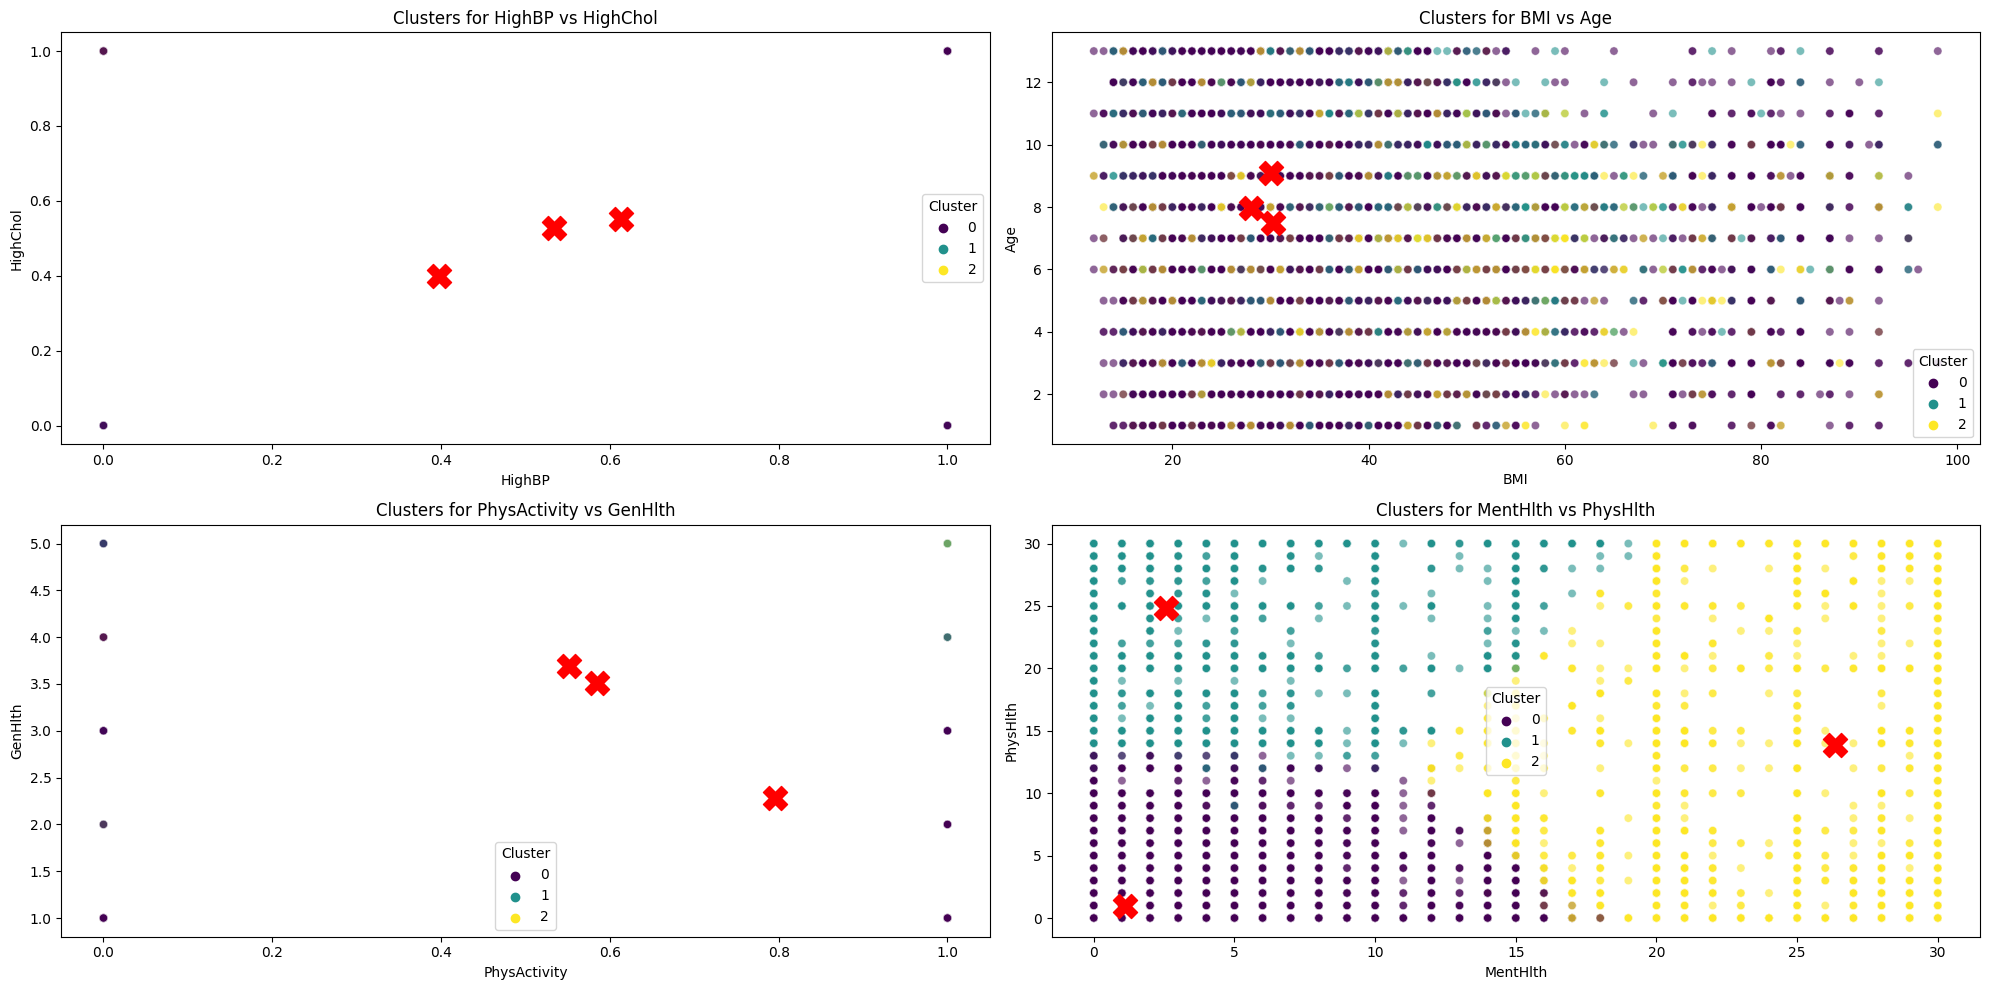

In [61]:
# Fit KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df)


column_names = df.columns[:-1]  # Exclude 'Cluster' column
assert len(column_names) == kmeans.cluster_centers_.shape[1], "Column count mismatch!"

# Create DataFrame for cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=column_names)
print(cluster_centers)


feature_pairs = [
    ('HighBP', 'HighChol'),
    ('BMI', 'Age'),
    ('PhysActivity', 'GenHlth'),
    ('MentHlth', 'PhysHlth')
]

plt.figure(figsize=(20, 10))

for i, (feature_x, feature_y) in enumerate(feature_pairs, 1):
    plt.subplot(2, 2, i)
    sb.scatterplot(data=df, x=feature_x, y=feature_y, hue='Cluster', palette='viridis', alpha=0.6)
    plt.scatter(cluster_centers[feature_x], cluster_centers[feature_y], s=300, c='red', marker='X')
    plt.title(f'Clusters for {feature_x} vs {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)

plt.tight_layout()
plt.show()

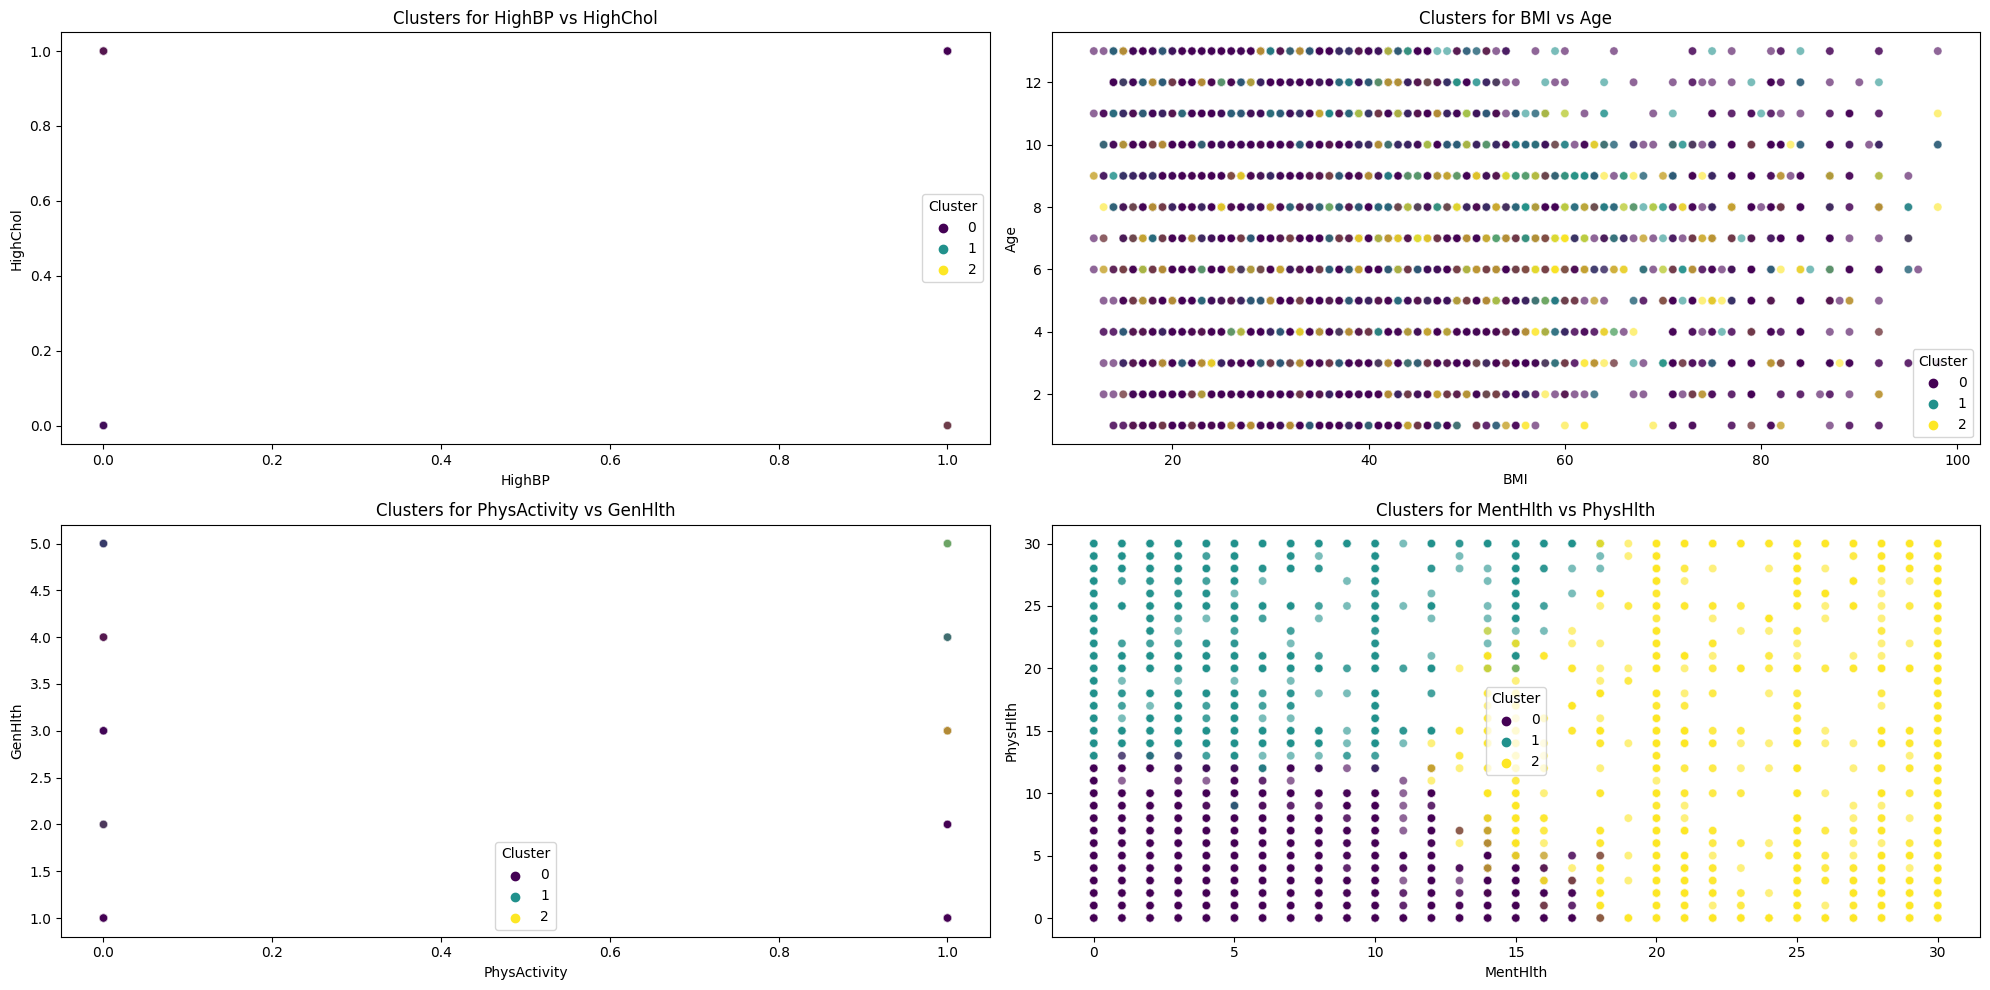

In [63]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming df is your DataFrame with features and target

# Split data into features and target
X = df.drop('Cluster', axis=1)  # Features
y = df['Cluster']  # Target

# Fit kNN with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

# Predict clusters for each data point
df['Cluster'] = knn.predict(X)

# Plot clusters
feature_pairs = [
    ('HighBP', 'HighChol'),
    ('BMI', 'Age'),
    ('PhysActivity', 'GenHlth'),
    ('MentHlth', 'PhysHlth')
]

plt.figure(figsize=(20, 10))

for i, (feature_x, feature_y) in enumerate(feature_pairs, 1):
    plt.subplot(2, 2, i)
    sb.scatterplot(data=df, x=feature_x, y=feature_y, hue='Cluster', palette='viridis', alpha=0.6)
    plt.title(f'Clusters for {feature_x} vs {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)

plt.tight_layout()
plt.show()
